# 1.この課題の目的
スクラッチを通してニューラルネットワークの発展的内容を理解する
以下の要件をすべて満たしていた場合、合格とします。

※Jupyter Notebookを使い課題に沿った検証や説明ができている。

# 2.スクラッチによる実装
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

前回作成した3層のニューラルネットワークを、クラスを活用することで、任意の構成に拡張しやすいコードに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。

このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。

新たなニューラルネットワーク分類器のクラスを作成する
Sprint9で作成したものとは別に、ニューラルネットワーク分類器のクラスScratchDeepNeuralNetrowkClassifierを作成してください。

## 層などのクラス化
コーディング

クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。

### 手を加える箇所

層の数
層の種類（今後は畳み込み層など他のタイプの層が登場する）
活性化関数の種類
重みやバイアスの初期化方法
最適化手法
そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用する。それぞれのクラスについてはこのあと解説します。

## サンプルコード1
（ScratchDeepNeuralNetrowkClassifierのfitメソッド内）
```python

# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数

optimizer = SGD(self.lr)
self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
self.activation1 = Tanh()
self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
self.activation2 = Tanh()
self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
self.activation3 = Softmax()
```

## サンプルコード2
（イテレーションごとのフォワード）
```python
A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1)
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)
```

## サンプルコード3
（イテレーションごとのバックワード）
```python
dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
```

# コーディング開始

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy

# 評価値のクラスをインポート
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import precision_recall_fscore_support


from sklearn import preprocessing
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder

# データ読み込み

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


# 平滑化

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化

In [4]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 標準化

In [5]:
# std = preprocessing.StandardScaler()
# X_train_pre = std.fit_transform(X_train)

# 検証データ8割と正解データ2割に分割

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


# GetMiniBatchクラス

In [7]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# 【問題1】全結合層のクラス化
## コーディング

全結合層のクラスの雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。

重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself = self.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

雛形

```python
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        pass
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        pass
        return A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        pass
        # 更新
        self = self.optimizer.update(self)
        return dZ


```

## FCクラス

In [8]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : インスタンス
        初期化クラスのインスタンス
    optimizer :　インスタンス
        最適化クラスのインスタンス
    
    atribute
    ----------
    self.forward_input : numpy配列
        順伝搬時の入力
    self.backward_input : numpy配列
        逆伝搬時の入力
    self.W : numpy配列
        重み
    self.B : numpy配列
        バイアス項
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.forward_input = None
        self.backward_input = None
        self.initializer = initializer
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        
        # 初期化
        # self.initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self)
        self.B = self.initializer.B(self)

    def forward(self, forward_input):
        """
        順伝搬
        Parameters
        ----------
        forward_input : numpy配列
            順伝搬の入力
            
        Returns
        ----------
        forward_output : numpy配列
            順伝搬の出力
        """     
        # forward_inputを取得
        self.forward_input = forward_input.copy()

        # 乗算レイヤと加算レイヤを通過した値を計算
        forward_output = (self.forward_input @ self.W) + self.B

        return forward_output
    

    def backward(self, backward_input):
        """
        逆伝搬
        Parameters
        ----------
        backward_input : numpy配列
            逆伝搬時の入力
        Returns
        ----------
        backward_output : numpy配列
            逆伝搬の出力
        """

        # backward_inputを取得
        self.backward_input = backward_input
        
        # 重みとバイアス項をoptimizerで設定したクラスのupdateメソッドで更新
        self = self.optimizer.update(self)
        
        # 前の層への出力を計算
        backward_output = self.backward_input @ self.W.T

        return backward_output

# 【問題2】初期化方法のクラス化
前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

雛形

```python
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
    """
    重みの初期化
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数

    Returns
    ----------
    W :
    """
        pass
        return W
    def B(self, n_nodes2):
    """
    バイアスの初期化
    Parameters
    ----------
    n_nodes2 : int
      後の層のノード数

    Returns
    ----------
    B :
    """
        pass
        return B
````


# SimpleInitializerクラス

In [9]:
class SimpleInitializer():
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
        
    def W(self, layer):
        
        """
        重みの初期化

        Returns
        ----------
        layer :　インスタンス
            FC層のインスタンス
            
        Return
        ----------
        W : numpy配列
            初期化後の重み
        """
        # 重みの初期値を計算
        W = self.sigma * np.random.randn(layer.n_nodes1, layer.n_nodes2)

        return W
    

    def B(self, layer):
        """
        バイアスの初期化
        Parameters
        ----------
        layer :　インスタンス
            FC層のインスタンス

        Returns
        ----------
        B :　numpy配列
            初期化後のバイアス項
        """
        # バイアス項の初期値を計算
        B = self.sigma * np.random.randn(1, layer.n_nodes2)
        
        return B

# 【問題3】最適化手法のクラス化
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself = self.optimizer.update(self)のように更新できるようにします。こちらも雛形を用意しましたので、必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

雛形
```python
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        return layer
```

# SGDクラス

In [10]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前のFC層のインスタンス

        Returns
        ----------
        layer : 更新後のFC層のインスタンス
        """
        # 重みとバイアスの微分値(値を更新する量)
        derivative_of_bias = layer.backward_input.sum(axis=0)
        derivative_of_weight = layer.forward_input.T @ layer.backward_input

        # バイアスの更新
        layer.W -= self.lr * (derivative_of_weight / layer.backward_input.shape[0])
        layer.B -= self.lr * (derivative_of_bias / layer.backward_input.shape[0])
        
        return layer

# 【問題4】活性化関数のクラス化
活性化関数もクラス化を行なってください。

上記サンプルコード3ではソフトマックス関数のバックプロパゲーションに交差エントロピー誤差の計算も含む実装を想定しています。

# Softmax_withlossクラス

In [11]:
class Softmax_withloss():
    
    def __init__(self):
        """
        ソフトマックス関数とロス関数を計算

        atribute
        ----------
        self.forward_output : numpy配列
            順伝搬の出力
        self.batch_size : int
            バッチサイズ
        """
        
        self.forward_output = None
        self.batch_size = None
    
    def forward(self, FC_output):
        """
        順伝搬
        Parameters
        ----------
        FC_output : numpy配列
            FC層の順伝搬時の出力データ

        Returns
        ----------
        self.forward_output : numpy配列
            順伝搬の出力データ
        """
        self.forward_output = self.softmax(FC_output)
        return self.forward_output
    
    def backward(self, teacher_data):
        """
        逆伝搬
        Parameters
        ----------
        teacher_data : numpy配列
            正解データ

        Returns
        ----------
        backward_output : numpy配列
            逆伝搬の出力データ
        """

        backward_output = self.forward_output - teacher_data

        return backward_output
    
    def softmax(self, FC_output):
        """
        ソフトマックス関数を計算
        Parameters
        ----------
        FC_output : FC層の順伝搬時の出力データ
            正解データ

        Returns
        ----------
        softmax_output : numpy配列
            ソフトマックス関数の出力
        """
        # 最大値を取得
        FC_output_max = np.max(FC_output, axis=1)
        # オーバーフロー対策の為、各値から最大値を引く
        exp_FC_output = np.exp(FC_output - FC_output_max.reshape(-1, 1))
        sum_exp_FC_output = np.sum(exp_FC_output, axis=1).reshape(-1, 1)
        # ソフトマックス関数を計算
        softmax_output = exp_FC_output / sum_exp_FC_output
        
        return softmax_output
    
    def cross_entropy_error(self, teacher_data):
        """
        クロスエントロピー誤差を計算
        Parameters
        ----------
        teacher_data : numpy配列
            正解データ

        Returns
        ----------
        loss_per_batch_size : numpy配列
            １データ毎のクロスエントロピー誤差
        """
        # クロスエントロピー誤差を計算
        loss = teacher_data * (np.log(self.forward_output + 1e-05)) # ゼロ除算対策
        total_loss = -np.sum(loss)
        loss_per_batch_size = total_loss /teacher_data.shape[0]
        return loss_per_batch_size

# 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装します。

ReLUは以下の数式です。

$$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

$x$ : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。

[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html)

一方、バックプロパゲーションのための 
$x$ に関する $f(x)$の微分は以下のようになります。

$$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

数学的には微分可能ではないですが、 $x=0$のとき $0$とすることで対応しています。

フォワード時の$x$の正負により、勾配を逆伝播するかどうかが決まるということになります。

# Sigmoidクラス

In [12]:
class Sigmoid():
    
    """
    シグモイド関数を計算

    atribute
    ----------
    self.forward_output : numpy配列
        FC層の順伝搬時の出力データ
    """
    
    def __init__(self):
        self.forward_output = None
    
    
    def forward(self, forward_input):
        """
        順伝搬
        Parameters
        ----------
        forward_input : numpy配列
            FC層の順伝搬時の出力データ
            
        Returns
        ----------
        self.forward_output : numpy配列
            順伝搬の出力データ
        """
        # オーバーフロー対策の為、eの乗数の最大値、最小値を設定
        self.forward_output = 1.0 / (1.0 + np.exp(-forward_input))
        return self.forward_output
    
    def backward(self, backward_input):
        """
        逆伝搬
        Parameters
        ----------
        backward_input : numpy配列
            FC層の逆伝搬時の出力データ
            
        Returns
        ----------
        backward_output : numpy配列
            逆伝搬の出力データ
        """
        backward_output = backward_input  * (1 - self.forward_output) * self.forward_output
        return backward_output

# Reluクラス

In [13]:
class Relu():
    """
    Relu関数を計算

    atribute
    ----------
    self.forward_input : numpy配列
        FC層の順伝搬時の出力データ
    """
    def __init__(self):
        self.forward_input = None
        return
    
    def forward(self, forward_input):
        """
        順伝搬
        Parameters
        ----------
        forward_input : numpy配列
            FC層の順伝搬時の出力データ
            
        Returns
        ----------
        forward_output : numpy配列
            順伝搬の出力データ
        """
        self.forward_input = forward_input
        forward_output = np.maximum(0, self.forward_input)
        return forward_output
    
    def backward(self, backward_input):
        """
        逆伝搬
        Parameters
        ----------
        backward_input : numpy配列
            FC層の逆伝搬時の出力データ
            
        Returns
        ----------
        backward_output : numpy配列
            逆伝搬の出力データ
        """
        backward_output = backward_input * (np.where(self.forward_input > 0., 1., 0.))

        return backward_output

# Tanhクラス

In [14]:
class Tanh():
    """
    Tanh関数を計算

    atribute
    ----------
    self.forward_output : numpy配列
        順伝搬の出力データ
    """

    def __init__(self):
        # foward実施時の計算結果を格納する変数
        self.forward_output = None

        return
    
    def forward(self, forward_input):
        """
        順伝搬
        Parameters
        ----------
        forward_input : numpy配列
            FC層の順伝搬時の出力データ
            
        Returns
        ----------
        self.forward_output : numpy配列
            順伝搬の出力データ
        """
        # 計算結果を格納しreturnする
        self.forward_output = np.tanh(forward_input)
        return self.forward_output

    def backward(self, backward_input):
        """
        逆伝搬
        Parameters
        ----------
        backward_input : numpy配列
            FC層の逆伝搬時の出力データ
            
        Returns
        ----------
        backward_output : numpy配列
            逆伝搬の出力データ
        """

        backward_output = backward_input * (1 - np.tanh(self.forward_output) ** 2)
        return backward_output

# 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、一般的に良い初期値の取り方が知られています。

シグモイド関数やハイパボリックタンジェント関数のときはXavierの初期値（またはGlorotの初期値）、ReLUのときはHeの初期値が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成します。

それぞれの初期化方法における 
σ
 は次の式で求められます。

「Xavierの初期値」

$$
\sigma = \frac{1}{\sqrt{n}}
$$

$n$ : 前の層のノード数

（論文）

[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

「Heの初期値」


$$
\sigma = \sqrt{\frac{2}{n}}
$$

$n$ : 前の層のノード数

（論文）

[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf)

# XavierInitializerクラス

In [15]:
class XavierInitializer:
    
    """
    重みとバイアスの初期値を設定(Xavierの初期値)
    """
    
    def __init__(self):
        pass

        
    def W(self, layer):
        """
        重みを初期化

        Returns
        ----------
        layer : 更新前のFC層のインスタンス
        
        Return
        ----------
        W : numpy配列
            初期化後の重み
        """
    
        W = np.random.randn(layer.n_nodes1, layer.n_nodes2) / np.sqrt(layer.n_nodes1)
        
        return W

    def B(self, layer):
        """
        バイアス項を初期化

        Returns
        ----------
        layer : 更新前のFC層のインスタンス
        
        Return
        ----------
        B : numpy配列
            初期化後のバイアス項
        """
        
        B = np.random.randn(1, layer.n_nodes2) / np.sqrt(layer.n_nodes1)
        
        return B

# HeInitializerクラス

In [16]:
class HeInitializer:
    
    """
    重みとバイアスの初期値を設定(Heの初期値)
    """
    
    def __init__(self):
        pass
    
    def W(self, layer):
        """
        重みを初期化

        Returns
        ----------
        layer : 更新前のFC層のインスタンス
        
        Return
        ----------
        W : numpy配列
            初期化後の重み
        """
    
        W = np.random.randn(layer.nodes1, layer.n_nodes2) / (np.sqrt(layer.n_nodes1) * np.sqrt(2))

        return W
    
    
    def B(self):
        """
        バイアス項を初期化

        Returns
        ----------
        layer : 更新前のFC層のインスタンス
        
        Return
        ----------
        B : numpy配列
            初期化後のバイアス項
        """

        B = np.random.randn(1, layer.n_nodes2) / (np.sqrt(layer.n_nodes1) * np.sqrt(2))

        return B

# 【問題7】最適化手法
コーディング

学習率は学習の良し悪しにとって重要なハイパーパラメータであり、これを学習過程で変化させていく方法が現在では一般的です。様々な手法が提案されていますが、今回はその中でも基本的な、AdaGradを実装します。

まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

$α$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）

$\frac{\partial L}{\partial W_i}:W_i$に関する損失 

$\frac{\partial L}{\partial B_i}:B_i$に関する損失 

$E():$ミニバッチ方向にベクトルの平均を計算

続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$を保存しておき、その分だけ学習率を小さくします。

学習率は重み一つひとつに対して異なることになります。

$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）

$H_i^{\prime}$ : 更新した 
H
i
AdaGradクラスを作成し、上記の数式にもとづいて実装してください。


[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

# AdaGradクラス

In [17]:
class AdaGrad:
    """
    AdaGradにて重みとバイアス項を更新する
    Parameters
    ----------
    backward_input : numpy配列
        FC層の逆伝搬時の出力データ

    atribute
    ----------
    self.lr : float
        学習率
    self.h_W : numpy配列
        重みの微分値の２乗和の総和
    self.h_B : numpy配列
        バイアス項の微分値の２乗和の総和
    """
    
    def __init__(self, lr):
        self.lr = lr
        self.h_W = None
        self.h_B = None
        
    def update(self, layer):
        """
        AdaGradにて重みとバイアス項を更新する
        
        atribute
        ----------
        self.lr : float
            学習率
        self.h_W : numpy配列
            重みの微分値の２乗和の総和
        self.h_B : numpy配列
            バイアス項の微分値の２乗和の総和
        """
        if self.h_W is None:
            self.h_W = np.zeros_like(layer.W)

        if self.h_B is None:
            self.h_B = np.zeros_like(layer.B)
        
        # 重みとバイアスの微分値(値を更新する量)
        derivative_of_weight = (layer.forward_input.T @ layer.backward_input) / layer.backward_input.shape[0]
        derivative_of_bias = (layer.backward_input.sum(axis=0)) /  layer.backward_input.shape[0]
        
        self.h_W += derivative_of_weight * derivative_of_weight
        self.h_B += derivative_of_bias * derivative_of_bias

        # バイアスの更新
        layer.W -= self.lr * (derivative_of_weight / layer.backward_input.shape[0]) / (np.sqrt(self.h_W) + 1e-7)
        layer.B -= self.lr * (derivative_of_bias / layer.backward_input.shape[0]) / (np.sqrt(self.h_B) + 1e-7)
        
        return layer

# ScratchDeepNeuralNetrowkClassifierクラス

In [32]:
class ScratchDeepNeuralNetrowkClassifier():
    
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------
    lr :　float
        学習率
    sigma　：　float
        ガウス分布の標準偏差
    batch_size : int
        バッチサイズ
    n_features : int
        特徴量の数
    n_nodes1 : int
        1層目のノード数
    n_nodes2 : int
        2層目のノード数
    n_output : int
        出力のクラス数（3層目のノード数）
    verbose : bool
        学習結果を表示するかを設定するフラグ
    
    Attributes
    ----------
    # 損失を記録する配列を用意
    self.loss : list
        エポック毎の学習用データに対するロスを格納しているリスト
    self.val_loss : list
        エポック毎の検証用データに対するロスを格納しているリスト
    self.verification_flag : bool
        検証用データの有無を設定するフラグ
    self.layers : OrderdDict
        各層のインスタンスを格納する辞書
    """

    def __init__(self,lr, sigma, batch_size, n_epochs, n_features, n_nodes1, n_nodes2, n_output,\
                         initializer, activater, optimizer, verbose=None):

        self.lr = lr # 学習率
        self.sigma = sigma # ガウス分布の標準偏差
        self.batch_size = batch_size # バッチサイズ
        self.n_epochs = n_epochs # エポック数
        self.n_features = n_features # 特徴量の数
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        self.verbose = verbose# 学習結果を表示するかを設定するフラグ
    
    
    
        init_dict = {'Sim' : SimpleInitializer(sigma=self.sigma),
                             'Xa' : XavierInitializer(),
                             'He' : HeInitializer()}
        
        act_dict = {'Sig' : Sigmoid(), 'Relu' : Relu(), 'Tanh' : Tanh()}
        
        opt_dict = {'SGD' : SGD(lr=self.lr), 'AdaGrad' : AdaGrad(lr=self.lr)}
        
        init = init_dict[initializer]
        act = act_dict[activater]
        opt = opt_dict[optimizer]

        
        # 損失を記録する配列を用意
        self.loss_list = []
        self.val_loss_list = []
        
        self.verification_flag = None
        
        self.layers = OrderedDict()
        self.layers['FC1'] = FC(n_nodes1=self.n_features, n_nodes2=self.n_nodes1,\
                                initializer=copy.deepcopy(init), optimizer=copy.deepcopy(opt))
        self.layers['ACT1'] = copy.deepcopy(act)
        
        self.layers['FC2'] = FC(n_nodes1=self.n_nodes1, n_nodes2=self.n_nodes2,\
                                initializer=copy.deepcopy(init), optimizer=copy.deepcopy(opt))
        self.layers['ACT2'] = copy.deepcopy(act)
        
        
        self.layers['FC3'] = FC(n_nodes1=self.n_nodes2, n_nodes2=self.n_output,\
                                initializer=copy.deepcopy(init), optimizer=copy.deepcopy(opt))
        
        self.layers['Last_layer'] = Softmax_withloss()
        
        

    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X_train : numpy配列
            学習用データの特徴データ
        y_train : numpy配列
            学習用データの正解データ
        X_val : numpy配列
            検証用データの特徴データ
        y_val : numpy配列
            検証用データの正解データ
        """
        # 検証データの有無を記録するフラグ
        if X_val is not None and y_val is not None:
            self.verification_flag = True
        
        # OneHotEncoding
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
        
        # 検証用データの有無を確認し、self.verification_flagを更新
        if self.verification_flag:
            y_val_one_hot = enc.transform(y_val[:, np.newaxis])
        
        """
        ミニバッチ処理開始
        """
        #ミニバッチ処理を行うインスタンスを作成

        for e in range(self.n_epochs):
            get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=self.batch_size)
            
            # バッチサイズ毎にデータを取得し、順伝搬、逆伝搬を行い重みとバイアス項を更新する
            for mini_X_train, mini_y_train in get_mini_batch_train:
                _ = self.forward(mini_X_train)
                self.backward(mini_y_train)

            # 学習用データとのロスを計算しリストに格納
            train_loss = self.loss(X_train, y_train_one_hot)
            self.loss_list.append(train_loss)

            # 検証用データの有無を判別→データが存在する場合、検証用データとのロスを計算しリストに格納
            if self.verification_flag:
                val_loss = self.loss(X_val, y_val_one_hot)
                self.val_loss_list.append(val_loss)

                
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                
                # 指定エポック数が10より大きい数字かを判別
                if self.n_epochs > 10:
                    
                    # True→10回に１回に学習過程を表示する
                    if ((e+1)%10) == 0:
                        print('{}epoch目\n'.format(e + 1))
                        print('学習用正解データとの誤差　：　{:.4f}\n'.format(train_loss))

                        if self.verification_flag:
                            print('検証用正解データとの誤差　：　{:.4f}\n'.format(val_loss))
                        print('------------------------------------------------')
                        
                # False→1epochごとに学習過程を表示する
                else:
                    
                    print('{}epoch目\n'.format(e + 1))
                    print('学習用正解データとの誤差　：　{:.4f}\n'.format(train_loss))

                    if self.verification_flag:
                        print('検証用正解データとの誤差　：　{:.4f}\n'.format(val_loss))
                    print('------------------------------------------------')


    def predict(self, test_data):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        test_data : numpy配列
            テストデータ

        Returns
        -------
        y_pred : numpy配列
            推定結果
        """
        # 順伝搬の出力(最後の層はsoftmaxなので、各クラスの予測確率)を計算
        forward_output = self.forward(test_data)
        
        # 最も高い値のindexを出力する
        y_pred = np.argmax(forward_output, axis=1)
        
        return y_pred

    
    # 順伝搬
    def forward(self, input_data):
        """
        順伝搬

        Parameters
        ----------
        input_data : numpy配列
            入力データ

        Returns
        -------
        forward_output : numpy配列
            順伝搬の出力
        """

        forward_output = input_data
        
        # 順伝搬の出力の計算
        # 各層を順にlayerに格納し順伝搬の計算を行い、出力結果を次の層のforwardメソッドに入力していく
        for layer in self.layers.values():
            forward_output = layer.forward(forward_output)

        return forward_output
        
    
    # 誤差逆伝搬
    def backward(self,teacher_data):
        """
        逆伝搬

        Parameters
        ----------
        teacher_data : numpy配列
            入力データ
        """

        backward = teacher_data
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            backward = layer.backward(backward)

            
            
    def loss(self, input_data, teacher_data):
        """
        ロスを計算

        Parameters
        ----------
        input_data : numpy配列
            入力データ
        teacher_data : numpy配列
            正解データ

        Returns
        -------
        loss_per_batch_size : numpy配列
            １データ毎のクロスエントロピー誤差
        """
        
        forward_output = self.forward(input_data)
        loss_per_batch_size = self.layers['Last_layer'].cross_entropy_error(teacher_data)
        
        return loss_per_batch_size
        

    def plot_learning_curve(self):
        """
        学習曲線を表示(学習データに対してのロス・検証データに対してのロス)
        """
        plt.plot(range(self.n_epochs), self.loss_list, label='loss')
        plt.plot(range(self.n_epochs), self.val_loss_list, label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('mse')
        plt.title('Learning curve')
        plt.legend()
        return

## 動作確認

## 環境①
- バッチサイズ : 10
- エポック数 : 10
- n_node1 : 200
- n_node2 : 400
- 初期化方法 : Simple
- 活性化関数 : Tanh
- 最適化方法 : SGD

## 考察
- 学習データ、検証データ共にエポック毎にロスが低下している事を確認

In [19]:
cls = ScratchDeepNeuralNetrowkClassifier(lr=0.01, sigma=0.1, batch_size=10, n_epochs=10, n_features=784,\
                                           n_nodes1=200, n_nodes2=400, n_output=10,\
                                           initializer='Sim', activater='Tanh', optimizer='SGD', verbose=True)

cls.fit(X_train, y_train, X_val, y_val)

1epoch目

学習用正解データとの誤差　：　0.2404

検証用正解データとの誤差　：　0.2586

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　0.1827

検証用正解データとの誤差　：　0.2065

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　0.1485

検証用正解データとの誤差　：　0.1765

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　0.1256

検証用正解データとの誤差　：　0.1573

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　0.1088

検証用正解データとの誤差　：　0.1439

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　0.0957

検証用正解データとの誤差　：　0.1341

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　0.0850

検証用正解データとの誤差　：　0.1265

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　0.0758

検証用正解データとの誤差　：　0.1205

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　0.0677

検証用正解データとの誤差　：　0.1156

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　0.0606

検証用正解データとの誤差　：　0.1115

--------

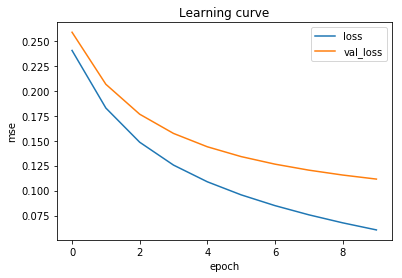

In [20]:
cls.plot_learning_curve()

## 環境②
- バッチサイズ : 10
- エポック数 : 10
- n_node1 : 200
- n_node2 : 400
- 初期化方法 : Simple
- 活性化関数 : Tanh
- 最適化方法 : AdaGrad

## 考察
- 学習データ、検証データ共にエポック毎にロスが低下している事を確認
- 検証データに対する学習曲線がより学習データに対する学習曲線に近くなっている→環境①と比較しAdaGradを使用した環境②の方が汎化性能が高い

In [21]:
cls2 = ScratchDeepNeuralNetrowkClassifier(lr=0.01, sigma=0.1, batch_size=10, n_epochs=10, n_features=784,\
                                           n_nodes1=200, n_nodes2=400, n_output=10,\
                                           initializer='Sim', activater='Tanh', optimizer='AdaGrad', verbose=True)

cls2.fit(X_train, y_train, X_val, y_val)

1epoch目

学習用正解データとの誤差　：　0.3278

検証用正解データとの誤差　：　0.3402

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　0.2917

検証用正解データとの誤差　：　0.3056

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　0.2729

検証用正解データとの誤差　：　0.2879

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　0.2602

検証用正解データとの誤差　：　0.2762

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　0.2506

検証用正解データとの誤差　：　0.2674

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　0.2429

検証用正解データとの誤差　：　0.2604

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　0.2364

検証用正解データとの誤差　：　0.2546

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　0.2308

検証用正解データとの誤差　：　0.2497

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　0.2259

検証用正解データとの誤差　：　0.2453

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　0.2215

検証用正解データとの誤差　：　0.2415

--------

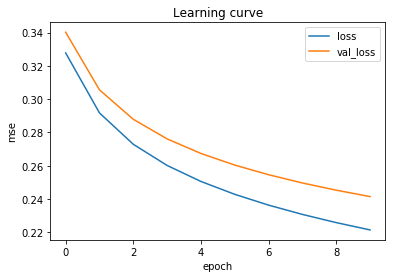

In [22]:
cls2.plot_learning_curve()

## 環境③
- バッチサイズ : 10
- エポック数 : 10
- バッチサイズ : 32
- n_node1 : 200
- n_node2 : 400
- 初期化方法 : Simple
- 活性化関数 : Relu
- 最適化方法 : AdaGrad

## 考察
- 学習データ、検証データ共にエポック毎にロスが低下している事を確認
- 学習データ・検証データそれぞれの学習曲線がほぼ同じ軌道を描いている→環境②と比較しReluを使用した環境③のモデルの方が汎化性能が高い

In [23]:
cls3 = ScratchDeepNeuralNetrowkClassifier(lr=0.01, sigma=0.1, batch_size=32, n_epochs=10, n_features=784,\
                                           n_nodes1=200, n_nodes2=400, n_output=10,\
                                           initializer='Sim', activater='Relu', optimizer='AdaGrad', verbose=True)

cls3.fit(X_train, y_train, X_val, y_val)

1epoch目

学習用正解データとの誤差　：　0.6191

検証用正解データとの誤差　：　0.6266

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　0.4839

検証用正解データとの誤差　：　0.4915

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　0.4241

検証用正解データとの誤差　：　0.4321

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　0.3885

検証用正解データとの誤差　：　0.3969

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　0.3641

検証用正解データとの誤差　：　0.3729

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　0.3459

検証用正解データとの誤差　：　0.3551

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　0.3314

検証用正解データとの誤差　：　0.3411

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　0.3197

検証用正解データとの誤差　：　0.3297

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　0.3097

検証用正解データとの誤差　：　0.3202

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　0.3012

検証用正解データとの誤差　：　0.3120

--------

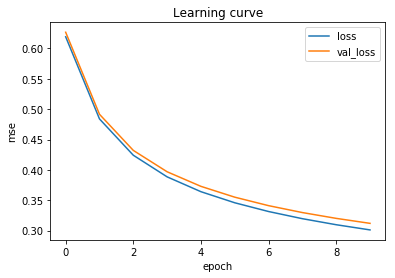

In [24]:
cls3.plot_learning_curve()

## 環境④
- バッチサイズ : 32
- エポック数 : 10
- バッチサイズ : 32
- n_node1 : 200
- n_node2 : 400
- 初期化方法 : Simple
- 活性化関数 : Sigmoid
- 最適化方法 : SGD

## 考察
- 学習データ、検証データ共にエポック毎にロスが低下している事を確認
- 6epochまでは学習データ・検証データ共にロスの低下率が低いが、それ以降は急激にロスが下がっている事を確認。

In [25]:
cls3 = ScratchDeepNeuralNetrowkClassifier(lr=0.01, sigma=0.01, batch_size=32, n_epochs=10, n_features=784,\
                                           n_nodes1=200, n_nodes2=400, n_output=10,\
                                           initializer='Sim', activater='Sig', optimizer='SGD', verbose=True)

cls3.fit(X_train, y_train, X_val, y_val)

1epoch目

学習用正解データとの誤差　：　2.3115

検証用正解データとの誤差　：　2.3137

------------------------------------------------
2epoch目

学習用正解データとの誤差　：　2.3114

検証用正解データとの誤差　：　2.3137

------------------------------------------------
3epoch目

学習用正解データとの誤差　：　2.3113

検証用正解データとの誤差　：　2.3136

------------------------------------------------
4epoch目

学習用正解データとの誤差　：　2.3112

検証用正解データとの誤差　：　2.3135

------------------------------------------------
5epoch目

学習用正解データとの誤差　：　2.3110

検証用正解データとの誤差　：　2.3132

------------------------------------------------
6epoch目

学習用正解データとの誤差　：　2.3106

検証用正解データとの誤差　：　2.3128

------------------------------------------------
7epoch目

学習用正解データとの誤差　：　2.3099

検証用正解データとの誤差　：　2.3122

------------------------------------------------
8epoch目

学習用正解データとの誤差　：　2.3087

検証用正解データとの誤差　：　2.3109

------------------------------------------------
9epoch目

学習用正解データとの誤差　：　2.3061

検証用正解データとの誤差　：　2.3083

------------------------------------------------
10epoch目

学習用正解データとの誤差　：　2.2998

検証用正解データとの誤差　：　2.3020

--------

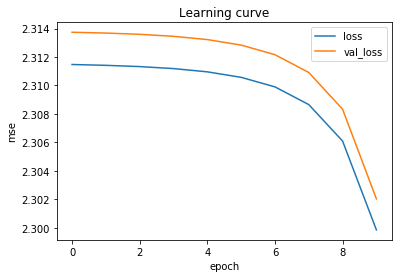

In [26]:
cls3.plot_learning_curve()

## 環境⑤
- バッチサイズ : 32
- エポック数 : 100
- バッチサイズ : 32
- n_node1 : 200
- n_node2 : 400
- 初期化方法 : Simple
- 活性化関数 : Sigmoid
- 最適化方法 : SGD

## 考察
- 学習データ、検証データ共にエポック毎にロスが低下している事を確認

In [34]:
cls4 = ScratchDeepNeuralNetrowkClassifier(lr=0.01, sigma=0.01, batch_size=32, n_epochs=100, n_features=784,\
                                           n_nodes1=200, n_nodes2=400, n_output=10,\
                                           initializer='Sim', activater='Sig', optimizer='SGD', verbose=True)

cls4.fit(X_train, y_train, X_val, y_val)

10epoch目

学習用正解データとの誤差　：　2.2998

検証用正解データとの誤差　：　2.3020

------------------------------------------------
20epoch目

学習用正解データとの誤差　：　0.7936

検証用正解データとの誤差　：　0.7918

------------------------------------------------
30epoch目

学習用正解データとの誤差　：　0.5450

検証用正解データとの誤差　：　0.5529

------------------------------------------------
40epoch目

学習用正解データとの誤差　：　0.4096

検証用正解データとの誤差　：　0.4217

------------------------------------------------
50epoch目

学習用正解データとの誤差　：　0.3342

検証用正解データとの誤差　：　0.3471

------------------------------------------------
60epoch目

学習用正解データとの誤差　：　0.2873

検証用正解データとの誤差　：　0.3029

------------------------------------------------
70epoch目

学習用正解データとの誤差　：　0.2493

検証用正解データとの誤差　：　0.2678

------------------------------------------------
80epoch目

学習用正解データとの誤差　：　0.2176

検証用正解データとの誤差　：　0.2386

------------------------------------------------
90epoch目

学習用正解データとの誤差　：　0.1917

検証用正解データとの誤差　：　0.2143

------------------------------------------------
100epoch目

学習用正解データとの誤差　：　0.1704

検証用正解データとの誤差　：　0.1945

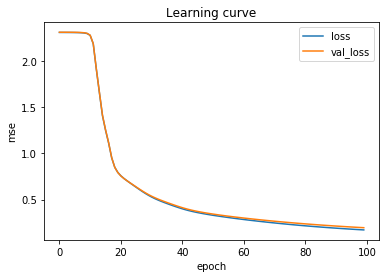

In [35]:
cls4.plot_learning_curve()